# Compare group knockoffs

This repeats the **AR1 and AR1(corr)** simulation in Fig 9 of [Spector and Janson](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short).  

+ target FDR = 10%
+ We generate equi, SDP, MVR, and ME group knockoffs using the true covariance matrix
+ Groups are defined via average linkake hierarchical clustering with cutoff varied as a parameter between 0.1-0.9 (larger value means smaller group sizes)

Simulation scripts



In [ ]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using ProgressMeter
using DataFrames, CSV
using DelimitedFiles

function run_group_knockoff_comparison(seed, ns, ar1_corr::Bool)
    target_fdr = 0.1
    m = 5
    p = 1000 # 500
    k = 50
    true_mu = zeros(p)

    # storage for results
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    sdp_subopt_powers, sdp_subopt_fdrs, sdp_subopt_times, sdp_subopt_ssums, sdp_subopt_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    me_powers, me_fdrs, me_times, me_ssums, me_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    num_groups = zeros(length(ns))

    # simulate Σ
    Random.seed!(seed)
    Σ = simulate_AR1(p, a=3, b=1)
    L = cholesky(Σ).L

    # simulate beta
    βtrue = zeros(p)
    if ar1_corr
        beta_start = rand(k:p-k)
        βtrue[beta_start:beta_start+k-1] .= randn(k)
    else
        βtrue[1:k] .= randn(k)
        shuffle!(βtrue)
    end

    for (idx, n) in enumerate(ns)
        try
            # simulate X
            X = randn(n, p) * L
            zscore!(X, mean(X, dims=1), std(X, dims=1))

            # simulate y
            ϵ = randn(n)
            y = X * βtrue + ϵ
            
            # define group
            groups = hc_partition_groups(X)
            num_groups[idx] += length(unique(groups))
            @show length(unique(groups))

            # find truly causal groups
            correct_groups = groups[findall(!iszero, βtrue)] |> unique

            # equi
            equi_t = @elapsed equi = modelX_gaussian_group_knockoffs(
                X, :equi, groups, true_mu, Σ, 
                m = m,
            )
            equi_ko_filter = fit_marginal(y, equi)
            fdr_idx = findfirst(x -> x == target_fdr, equi_ko_filter.fdr_target)
            selected = equi_ko_filter.selected[fdr_idx]
            equi_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            equi_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            equi_ssum = sum(abs.(equi_ko_filter.ko.S))

            # sdp
            sdp_t = @elapsed sdp = modelX_gaussian_group_knockoffs(
                X, :sdp, groups, true_mu, Σ, 
                m = m, tol=0.0001,
            )
            sdp_ko_filter = fit_marginal(y, sdp)
            selected = sdp_ko_filter.selected[fdr_idx]
            sdp_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            sdp_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            sdp_ssum = sum(abs.(sdp_ko_filter.ko.S))

            # subopt-sdp
#             subopt_sdp_t = @elapsed sdp_subopt = modelX_gaussian_group_knockoffs(
#                 X, :sdp_subopt, groups, #true_mu, Σ, 
#                 m = m,
#             )
#             sdpopt_ko_filter = fit_marginal(y, sdp_subopt)
#             selected = sdpopt_ko_filter.selected[fdr_idx]
#             subopt_sdp_power = length(intersect(correct_groups, selected)) / length(correct_groups)
#             subopt_sdp_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
#             subopt_sdp_ssum = sum(abs.(sdpopt_ko_filter.ko.S))

            # ME
            me_t = @elapsed me = modelX_gaussian_group_knockoffs(
                X, :maxent, groups, true_mu, Σ, 
                m = m, 
            )
            me_ko_filter = fit_marginal(y, me)
            selected = me_ko_filter.selected[fdr_idx]
            me_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            me_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            me_ssum = sum(abs.(me_ko_filter.ko.S))

            # MVR
            mvr_t = @elapsed mvr = modelX_gaussian_group_knockoffs(
                X, :mvr, groups, true_mu, Σ, 
                m = m, 
            )
            mvr_ko_filter = fit_marginal(y, mvr)
            selected = mvr_ko_filter.selected[fdr_idx]
            mvr_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            mvr_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            mvr_ssum = sum(abs.(mvr_ko_filter.ko.S))

            # update counters if all methods succeeded
            equi_powers[idx] += equi_power
            equi_fdrs[idx] += equi_fdr
            equi_times[idx] += equi_t
            equi_ssums[idx] += equi_ssum
            sdp_powers[idx] += sdp_power
            sdp_fdrs[idx] += sdp_fdr
            sdp_times[idx] += sdp_t
            sdp_ssums[idx] += sdp_ssum
#             sdp_subopt_powers[idx] += subopt_sdp_power
#             sdp_subopt_fdrs[idx] += subopt_sdp_fdr
#             sdp_subopt_times[idx] += subopt_sdp_t
#             sdp_subopt_ssums[idx] += subopt_sdp_ssum
            me_powers[idx] += me_power
            me_fdrs[idx] += me_fdr
            me_times[idx] += me_t
            me_ssums[idx] += me_ssum
            mvr_powers[idx] += mvr_power
            mvr_fdrs[idx] += mvr_fdr
            mvr_times[idx] += mvr_t
            mvr_ssums[idx] += mvr_ssum

            println("equi (n $n): power = $(equi_power), fdr = $(equi_fdr), t=$(equi_t), sum(s) = $(equi_ssum)")
#             println("subopt-SDP (c_corr $c_corr): power = $(subopt_sdp_power), fdr = $(subopt_sdp_fdr), t=$(subopt_sdp_t), sum(s) = $(subopt_sdp_ssum)")
            println("SDP (n $n): power = $(sdp_power), fdr = $(sdp_fdr), t=$(sdp_t), sum(s) = $(sdp_ssum)")
            println("ME (n $n): power = $(me_power), fdr = $(me_fdr), t=$(me_t), sum(s) = $(me_ssum)")
            println("mvr (n $n): power = $(mvr_power), fdr = $(mvr_fdr), t=$(mvr_t), sum(s) = $(mvr_ssum)\n")
        catch
            continue
        end
    end
    
    return equi_powers, equi_fdrs, equi_times, equi_ssums, 
        sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, 
#         sdp_subopt_powers, sdp_subopt_fdrs, sdp_subopt_times, sdp_subopt_ssums, 
        me_powers, me_fdrs, me_times, me_ssums, 
        mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, 
        num_groups
end

function run_one_simulation(seed, ar1_corr::Bool)
    outdir = ar1_corr ? "/home/groups/sabatti/group_knockoff_simulations/AR1_corr/sim$seed" : 
        "/home/groups/sabatti/group_knockoff_simulations/AR1/sim$seed"
    isdir(outdir) || mkpath(outdir)

    # run simulation
    ns = 250:250:1000
    equi_powers, equi_fdrs, equi_times, equi_ssums, 
        sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, 
        me_powers, me_fdrs, me_times, me_ssums, 
        mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, 
        num_groups = run_group_knockoff_comparison(seed, ns, ar1_corr)

    # save results
    for (i, n) in enumerate(ns)
        df = DataFrame(method = String[], power=Float64[], fdr=Float64[], time=Float64[], ssum=Float64[])
        push!(df, ["equi", equi_powers[i], equi_fdrs[i], equi_times[i], equi_ssums[i]])
        push!(df, ["sdp", sdp_powers[i], sdp_fdrs[i], sdp_times[i], sdp_ssums[i]])
        push!(df, ["me", me_powers[i], me_fdrs[i], me_times[i], me_ssums[i]])
        push!(df, ["mvr", mvr_powers[i], mvr_fdrs[i], mvr_times[i], mvr_ssums[i]])
        CSV.write(joinpath(outdir, "n$(n)_marginal.csv"), df)
    end
    writedlm(joinpath(outdir, "num_groups_marginal.txt"), num_groups)
end

# seed = 1111
# corr = true
seed = parse(Int, ARGS[1])
corr = parse(Bool, ARGS[2])
run_one_simulation(seed, corr)
println("finished.")


length(unique(groups)) = 618
length(unique(groups)) = 618
length(unique(groups)) = 619
length(unique(groups)) = 619
finished.


Submission script

In [1]:
function run_repeats(corr::Bool)
    simdir = "/home/groups/sabatti/group_knockoff_simulations"
    outdir = corr ? "/home/groups/sabatti/group_knockoff_simulations/AR1_corr" : 
        "/home/groups/sabatti/group_knockoff_simulations/AR1"
    for sim in 1:100
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=ar1_$sim")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=12G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(simdir)/run_AR1_marginal.jl $sim $corr'")
            println(io, "julia $(simdir)/run_AR1_marginal.jl $sim $corr")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim") 
        rm(filename, force=true)
    end
end
for corr in [true, false]
    run_repeats(corr)
end

Submitted batch job 24261001
submitted sim1
Submitted batch job 24261005
submitted sim2
Submitted batch job 24261007
submitted sim3
Submitted batch job 24261010
submitted sim4
Submitted batch job 24261013
submitted sim5
Submitted batch job 24261014
submitted sim6
Submitted batch job 24261016
submitted sim7
Submitted batch job 24261019
submitted sim8
Submitted batch job 24261021
submitted sim9
Submitted batch job 24261023
submitted sim10
Submitted batch job 24261025
submitted sim11
Submitted batch job 24261028
submitted sim12
Submitted batch job 24261031
submitted sim13
Submitted batch job 24261034
submitted sim14
Submitted batch job 24261036
submitted sim15
Submitted batch job 24261037
submitted sim16
Submitted batch job 24261038
submitted sim17
Submitted batch job 24261039
submitted sim18
Submitted batch job 24261042
submitted sim19
Submitted batch job 24261044
submitted sim20
Submitted batch job 24261045
submitted sim21
Submitted batch job 24261047
submitted sim22
Submitted batch job

Submitted batch job 24261402
submitted sim84
Submitted batch job 24261403
submitted sim85
Submitted batch job 24261404
submitted sim86
Submitted batch job 24261406
submitted sim87
Submitted batch job 24261407
submitted sim88
Submitted batch job 24261409
submitted sim89
Submitted batch job 24261410
submitted sim90
Submitted batch job 24261411
submitted sim91
Submitted batch job 24261412
submitted sim92
Submitted batch job 24261416
submitted sim93
Submitted batch job 24261423
submitted sim94
Submitted batch job 24261425
submitted sim95
Submitted batch job 24261427
submitted sim96
Submitted batch job 24261429
submitted sim97
Submitted batch job 24261431
submitted sim98
Submitted batch job 24261433
submitted sim99
Submitted batch job 24261436
submitted sim100


## Make plots

In [3]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

function summarize_ar(corr::Bool, n::Int)
    dir = corr ? "/home/groups/sabatti/group_knockoff_simulations/AR1_corr" :
        "/home/groups/sabatti/group_knockoff_simulations/AR1"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for seed in 1:100
        try
            result = CSV.read(joinpath(dir, "sim$seed", "n$(n)_marginal.csv"), DataFrame)
            push!(equi_powers, result[1, "power"]); push!(equi_fdrs, result[1, "fdr"])
            push!(sdp_powers, result[2, "power"]); push!(sdp_fdrs, result[2, "fdr"])
            push!(maxent_powers, result[3, "power"]); push!(maxent_fdrs, result[3, "fdr"])
            push!(mvr_powers, result[4, "power"]); push!(mvr_fdrs, result[4, "fdr"])
        catch
            continue
        end
    end
    println("n $n has $(length(equi_powers)) success")
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function make_plot_ar(corr::Bool; ns = 250:250:1000)
    equi_powers_mean, equi_fdrs_mean, equi_powers_std, equi_fdrs_std = [], [], [], []
    sdp_powers_mean, sdp_fdrs_mean, sdp_powers_std, sdp_fdrs_std = [], [], [], []
    maxent_powers_mean, maxent_fdrs_mean, maxent_powers_std, maxent_fdrs_std = [], [], [], []
    mvr_powers_mean, mvr_fdrs_mean, mvr_powers_std, mvr_fdrs_std = [], [], [], []
    
    # summarize results
    for n in ns
        equi_powers, maxent_powers, mvr_powers, sdp_powers, 
            equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
            summarize_ar(corr, n)
        push!(equi_powers_mean, mean(equi_powers)); push!(equi_powers_std, std(equi_powers))
        push!(equi_fdrs_mean, mean(equi_fdrs)); push!(equi_fdrs_std, std(equi_fdrs))
        push!(sdp_powers_mean, mean(sdp_powers)); push!(sdp_powers_std, std(sdp_powers))
        push!(sdp_fdrs_mean, mean(sdp_fdrs)); push!(sdp_fdrs_std, std(sdp_fdrs))
        push!(maxent_powers_mean, mean(maxent_powers)); push!(maxent_powers_std, std(maxent_powers))
        push!(maxent_fdrs_mean, mean(maxent_fdrs)); push!(maxent_fdrs_std, std(maxent_fdrs))
        push!(mvr_powers_mean, mean(mvr_powers)); push!(mvr_powers_std, std(mvr_powers))
        push!(mvr_fdrs_mean, mean(mvr_fdrs)); push!(mvr_fdrs_std, std(mvr_fdrs))
    end
    
    # power plot
    title = corr ? "AR1(corr)" : "AR1"
    power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
    plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

    # FDR plots
    fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
    plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end

AR1_power_plt, AR1_fdr_plt = make_plot_ar(false)
plot(AR1_power_plt, AR1_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

n 250 has 0 success


LoadError: MethodError: no method matching zero(::Type{Any})
[0mClosest candidates are:
[0m  zero(::Type{Union{Missing, T}}) where T at missing.jl:105
[0m  zero([91m::Union{Type{P}, P}[39m) where P<:Dates.Period at /share/software/user/open/julia/1.8.4/share/julia/stdlib/v1.8/Dates/src/periods.jl:53
[0m  zero([91m::T[39m) where T<:Dates.TimeType at /share/software/user/open/julia/1.8.4/share/julia/stdlib/v1.8/Dates/src/types.jl:450
[0m  ...

In [4]:
AR1_power_plt, AR1_fdr_plt = make_plot_ar(true)
plot(AR1_power_plt, AR1_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

n 250 has 0 success


LoadError: MethodError: no method matching zero(::Type{Any})
[0mClosest candidates are:
[0m  zero(::Type{Union{Missing, T}}) where T at missing.jl:105
[0m  zero([91m::Union{Type{P}, P}[39m) where P<:Dates.Period at /share/software/user/open/julia/1.8.4/share/julia/stdlib/v1.8/Dates/src/periods.jl:53
[0m  zero([91m::T[39m) where T<:Dates.TimeType at /share/software/user/open/julia/1.8.4/share/julia/stdlib/v1.8/Dates/src/types.jl:450
[0m  ...

n 250 has 100 success
n 500 has 100 success
n 750 has 100 success
n 1000 has 100 success


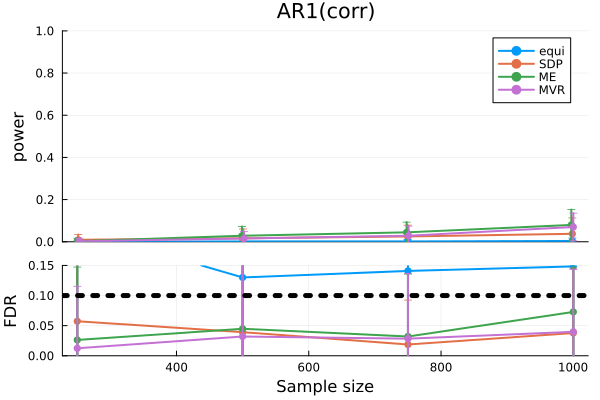

In [6]:
AR1_power_plt, AR1_fdr_plt = make_plot_ar(true)
plot(AR1_power_plt, AR1_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))